In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from datetime import datetime
import pysal
pd.options.mode.chained_assignment = None 
from geofeather import to_geofeather, from_geofeather
from matplotlib import pyplot as plt

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

/opt/anaconda/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [16]:
track_df = from_geofeather('Data/Monchengladbach.feather')
track_df.head()

index                        id                 time  \
0      0  5b46294f44ea850910a1c1e0  2018-07-11T06:07:23   
1      1  5b46294f44ea850910a1c1e2  2018-07-11T06:07:28   
2      2  5b46294f44ea850910a1c1e3  2018-07-11T06:07:33   
3      3  5b46294f44ea850910a1c1e4  2018-07-11T06:07:38   
4      4  5b46294f44ea850910a1c1e5  2018-07-11T06:07:43   

                   geometry  GPS Bearing.value GPS Bearing.unit  \
0  POINT (6.41455 51.20328)         117.943870              deg   
1  POINT (6.41512 51.20308)         115.088323              deg   
2  POINT (6.41564 51.20299)         106.541059              deg   
3  POINT (6.41615 51.20291)          99.885196              deg   
4  POINT (6.41671 51.20282)         104.435649              deg   

   Intake Temperature.value Intake Temperature.unit  MAF.value MAF.unit  ...  \
0                 28.000001                       c  35.669282      l/s  ...   
1                 28.000000                       c  31.446508      l/s  ...   
2                 28.000000                       c  28.072108      l/s  ...   
3                 28.000000                       c  33.429661      l/s  ...   
4                 27.999999                       c  25.774274      l/s  ...   

   Consumption.value Consumption.unit  Throttle Position.value  \
0                NaN             None                      NaN   
1                NaN             None                      NaN   
2                NaN             None                      NaN   
3                NaN             None                      NaN   
4                NaN             None                      NaN   

  Throttle Position.unit  track.appVersion track.touVersion  \
0                   None              None             None   
1                   None              None             None   
2                   None              None             None   
3                   None              None             None   
4                   None              None             None   

   O2 Lambda Voltage.value O2 Lambda Voltage.unit  O2 Lambda Voltage ER.value  \
0                      NaN                   None                         NaN   
1                      NaN                   None                         NaN   
2                      NaN                   None                         NaN   
3                      NaN                   None                         NaN   
4                      NaN                   None                         NaN   

  O2 Lambda Voltage ER.unit  
0                      None  
1                      None  
2                      None  
3                      None  
4                      None  

[5 rows x 55 columns]

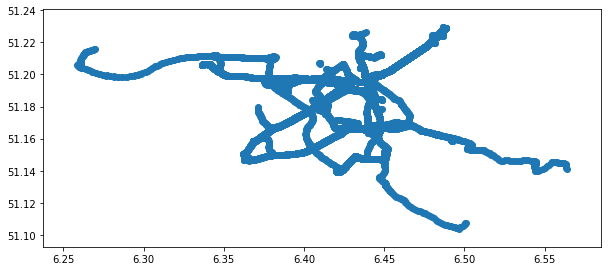

In [17]:
track_df.plot(figsize=(10, 12))

In [18]:
#fixing the speed values
#compare two speed values - GPS Speed.value and Speed.value
track_df['diff']= track_df ['GPS Speed.value']-track_df['Speed.value']
track_df['diff'].describe()

count    22005.000000
mean        -0.003303
std          3.095139
min        -48.999999
25%         -0.388510
50%          0.000000
75%          0.940252
max         58.100833
Name: diff, dtype: float64

/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([6.0000e+00, 1.0000e+01, 7.8000e+01, 5.6900e+02, 2.0735e+04,
        5.7700e+02, 2.2000e+01, 4.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-48.99999927, -38.28991608, -27.5798329 , -16.86974971,
         -6.15966653,   4.55041666,  15.26049984,  25.97058303,
         36.68066621,  47.3907494 ,  58.10083258]),
 <a list of 10 Patch objects>)

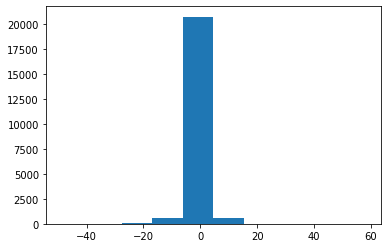

In [19]:
plt.hist(track_df['diff'])

In [20]:
#looking for small GPS speed which may mean they are stopping
# df[(df.a != -1) & (df.b != -1)]
track_df[['GPS Speed.value','Speed.value','diff']][track_df['GPS Speed.value'] <5]


GPS Speed.value  Speed.value      diff
14            0.000000     1.117746 -1.117746
15            0.000000     0.000000  0.000000
16            0.000000     0.000000  0.000000
17            0.000000     0.000000  0.000000
18            0.000000     0.000000  0.000000
...                ...          ...       ...
21994         0.000000     0.000000  0.000000
21995         0.000000     0.000000  0.000000
21996         0.000000     0.000000  0.000000
21997         0.000000     0.000000  0.000000
21998         1.669571     8.886700 -7.217128

[6133 rows x 3 columns]

In [141]:
from pysal import esda
import numpy as np

from pyproj import CRS
from pyproj import Transformer

inputCRS = CRS.from_epsg(4326)
outputCRS = CRS.from_epsg(25832)
transformer = Transformer.from_crs(inputCRS, outputCRS)
def project(a,b):
    return transformer.transform(a, b)


## select stopping times data
df_speed = track_df[track_df['Speed.value'] == 0]


# print(df_speed2['stopTimeSec'])

##group by geometry

df_speed['lat'] = df_speed['geometry'].apply(lambda coord: coord.y)
df_speed['lng'] = df_speed['geometry'].apply(lambda coord: coord.x)
# df_speed['time_sec'] = df_speed2['stopTime']
df_speed.reset_index()

data_speed2 = df_speed.groupby(['lat','lng'])[['stopTime']].sum().reset_index()

# #change this directory 
# #data_speed.to_csv('/home/poshan/Desktop/MSc/FloatingCar/envirocar-py/examples/data.csv')


Empty DataFrame
Columns: [index]
Index: []
Empty DataFrame
Columns: [index]
Index: []


In [151]:
## select stopping times data
df_speed = track_df[track_df['Speed.value'] == 0]

# convert the date column to datetime type
datetime_series = pd.to_datetime(df_speed['time'], format = "%Y-%m-%dT%H:%M:%S")
# print(date_series)
#datetimeindex
datetime_index = pd.DatetimeIndex(datetime_series.values)
# print(datetime_index)
#new df with the date as the index
df_speed2=df_speed.set_index(datetime_index)
df_speed2.drop('time',axis=1,inplace=True)
# print(df_speed2.index)
df_speed2['tvalue'] = df_speed2.index
df_speed2['stopTime'] = (df_speed2['tvalue']-df_speed2['tvalue'].shift()).fillna(pd.Timedelta('0 days'))
df_speed2['stopTimeSec'] = df_speed2['stopTime'].apply(lambda x: x.total_seconds())
# df_speed2

df_speed2['lat'] = df_speed2['geometry'].apply(lambda coord: coord.y)
df_speed2['lng'] = df_speed2['geometry'].apply(lambda coord: coord.x)
# df_speed['time_sec'] = df_speed2['stopTime']
df_speed2.reset_index()

data_speed2 = df_speed2.groupby(['lat','lng'])[['stopTimeSec']].sum().reset_index()

data_speed2.head()

lat       lng  stopTimeSec
0  51.127327  6.453458      -4547.0
1  51.131013  6.450902         66.0
2  51.131013  6.450902          5.0
3  51.131155  6.450722         14.0
4  51.131156  6.450722          5.0

In [22]:
data_speed['time_sec'].describe()

count    4296.000000
mean        5.786778
std         3.300640
min         5.000000
25%         5.000000
50%         5.000000
75%         5.000000
max        55.000000
Name: time_sec, dtype: float64

In [23]:
### calculate weights for getis ord
coords = [project(row['lat'], row['lng']) for index, row in data_speed.iterrows()]
w = pysal.weights.DistanceBand(coords, threshold= 50)
w
# coords

/opt/anaconda/lib/python3.7/site-packages/pysal/weights/weights.py:189: UserWarning: There are 31 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/opt/anaconda/lib/python3.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 0, 236, 245, 432, 459, 469, 470, 700, 733, 745, 817, 827, 829, 1173, 1215, 1216, 1775, 2004, 2075, 2796, 2841, 2854, 2915, 3122, 3192, 3249, 3420, 3936, 3937, 3944, 4233
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [24]:
#getisOrdGlobal = esda.getisord.G(data_speed['time_sec'], w)
getisOrdLocal = esda.getisord.G_Local(data_speed['time_sec'], w, transform='B')
getisOrdLocal.Zs

/opt/anaconda/lib/python3.7/site-packages/pysal/esda/getisord.py:434: RuntimeWarning: invalid value encountered in true_divide
  self.Zs = (self.Gs - self.EGs) / np.sqrt(self.VGs)


array([       nan, 0.58014737, 0.58014737, ..., 0.0329929 , 0.0329929 ,
       0.0329929 ])

In [25]:
data_speed['z_score'] = getisOrdLocal.Zs
data_speed['p_value'] = getisOrdLocal.p_norm
# data_speed[data_speed['p_value'] < 0.05]
# data_speed[data_speed['z_score'] == 0]
# data_speed_hotspots = data_speed[data_speed['z_score'] > 0 and data_speed['p_value'] < 0.05]
# hotspots1 = data_speed[data_speed['p_value'] < 0.05]
#query
# hotspot = data_speed.query('z_score > 0 & p_value < 0.05')
#two conditions
hotspot = data_speed[(data_speed.z_score > 0) & (data_speed.p_value <=0.05)]
coldspot = data_speed[(data_speed.z_score < 0) & (data_speed.p_value <=0.05)]

hotspot

lat       lng  time_sec   z_score   p_value
343   51.149929  6.388460         5  2.876666  0.002010
395   51.151751  6.363958         5  2.791307  0.002625
410   51.153101  6.451770        10  1.797107  0.036159
411   51.153102  6.451770         5  2.553771  0.005328
413   51.153103  6.451771         5  2.553771  0.005328
...         ...       ...       ...       ...       ...
4120  51.223306  6.482229         5  2.944209  0.001619
4121  51.223306  6.482229         5  2.944209  0.001619
4122  51.223626  6.482476         5  2.509764  0.006041
4123  51.223628  6.482476         5  2.509764  0.006041
4124  51.223628  6.482476         5  2.509764  0.006041

[593 rows x 5 columns]

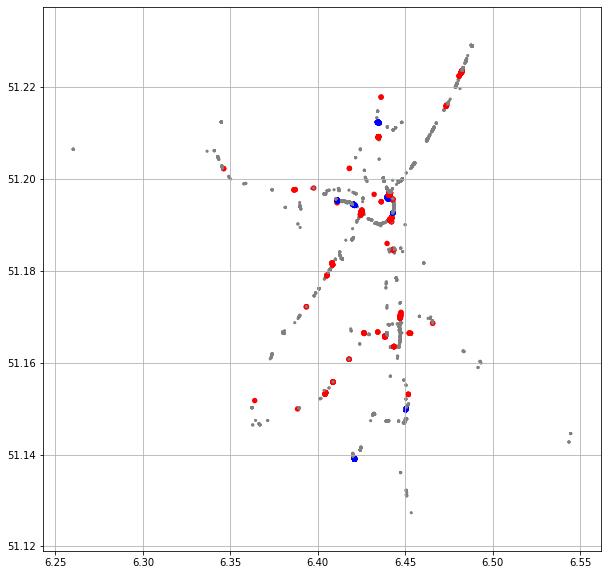

In [26]:
from matplotlib import pyplot as plt
#>1.96 hot spots
#<-1.96 cold spots
from matplotlib import colors as cls

f, axarr = plt.subplots(1, figsize=(10,10))
total_range = cls.Normalize(vmin = - 1.96, vmax = 1.96)

def pltcolor(p_value, z_score, confidence):
    cols=[]
    size=[]
    for p, z in zip(p_value, z_score):
        if p < confidence:
            if z > 0:
                cols.append('red')
                size.append(30)
            else:
                cols.append('blue')
                size.append(30)
        else:
            cols.append('grey')
            size.append(10)
    return cols , size


# Create the colors list using the function above
cols, sizes = pltcolor(data_speed['p_value'], data_speed['z_score'], 0.05)

plt.scatter(x=data_speed['lng'], y=data_speed['lat'], s=sizes, c=cols, lw = 0) #Pass on the list created by the function here
plt.grid(True)
plt.show()

In [27]:
import folium

lats = data_speed['lat']
lngs = data_speed['lng']

#z-value
z = data_speed['z_score']
p = data_speed['p_value']

avg_lat = sum(lats) / len(lats)
avg_lngs = sum(lngs) / len(lngs)

m = folium.Map(location=[avg_lat - 0.25, avg_lngs], tiles = 'Stamen Terrain', zoom_start=9)

color, sizes = pltcolor(p, z, 0.05)
time = data_speed['time_sec']
def makepopup(t):
    return str(t) + ' sec'

for lat,lng,c,s,t in zip(lats, lngs, color, sizes, time):
    radius = coords[2]
    folium.CircleMarker([lat,lng], color = c, radius = s/3, fill = c, popup = makepopup(t)).add_to(m)
m